In [44]:
# Import des librairies
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
import joblib
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)


I - Analyse 

La première partie du travail consiste à importer les données qui vont servir à entraîner et évaluer notre modèle. Cette étape est réalisé à l’aide  de la fonction read_csv de la librairie pandas
Les données comprennent 18 colonnes, 17 sont des features et 1 est la vérité terrain.

In [45]:
# Lecture du fichier CSV
df = pd.read_csv('car_insurance.csv')
#Afficher tout le détails de la dataframe lors des appels de fonctions suivants 
pd.set_option('display.max_columns', None)

Une fois l’import des données réalisé, le but est de se familiariser avec le jeu de données et d’en examiner les propriétés tel que le type de donnée (int, float,string) et les valeurs manquantes et les données aberrantes. Le but étant d’être capable de nettoyer ces données et de les standardiser pour les rendre exploitable par notre algorithme. 
En utilisant les fonctions relatives aux objets dataFrame, tel que df.info(),  df.isna(), df.describe() on est capable d’analyser l’ensemble des données.


In [46]:
# Affichage des premières lignes du DataFrame
print(f"head : \n{df.head()}\n")

head : 
       id  age  gender driving_experience    education         income  \
0  569520    3       0               0-9y  high school    upper class   
1  750365    0       1               0-9y         none        poverty   
2  199901    0       0               0-9y  high school  working class   
3  478866    0       1               0-9y   university  working class   
4  731664    1       1             10-19y         none  working class   

   credit_score  vehicle_ownership vehicle_year  married  children  \
0      0.629027                1.0   after 2015      0.0       1.0   
1      0.357757                0.0  before 2015      0.0       0.0   
2      0.493146                1.0  before 2015      0.0       0.0   
3      0.206013                1.0  before 2015      0.0       1.0   
4      0.388366                1.0  before 2015      0.0       0.0   

   postal_code  annual_mileage vehicle_type  speeding_violations  duis  \
0        10238         12000.0        sedan               

In [47]:
# Affichage des informations du DataFrame
print(f"info : \n{df.info}\n")

info : 
<bound method DataFrame.info of           id  age  gender driving_experience    education         income  \
0     569520    3       0               0-9y  high school    upper class   
1     750365    0       1               0-9y         none        poverty   
2     199901    0       0               0-9y  high school  working class   
3     478866    0       1               0-9y   university  working class   
4     731664    1       1             10-19y         none  working class   
...      ...  ...     ...                ...          ...            ...   
9995  323164    1       0             10-19y   university    upper class   
9996  910346    1       0             10-19y         none   middle class   
9997  468409    1       1               0-9y  high school   middle class   
9998  903459    1       0             10-19y  high school        poverty   
9999  442696    1       0               0-9y         none  working class   

      credit_score  vehicle_ownership vehicle_y

In [48]:
# Affichage des statistiques descriptives des données
df.describe()

,id,age,gender,credit_score,vehicle_ownership,married,children,postal_code,annual_mileage,speeding_violations,duis,past_accidents,outcome
count,10000.000000,10000.000000,10000.000000,9018.000000,10000.000000,10000.000000,10000.000000,10000.000000,9043.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,500521.906800,1.489500,0.499000,0.515813,0.697000,0.498300,0.708600,19864.548400,11697.003207,7.787500,0.23920,1.056300,0.313300
std,290030.768758,1.025278,0.500024,0.137688,0.459578,0.500022,1.350433,18915.613855,2818.434528,434.038859,0.55499,1.652454,0.463858
min,101.000000,0.000000,0.000000,0.053358,0.000000,0.000000,0.000000,10238.000000,2000.000000,0.000000,0.00000,0.000000,0.000000
25%,249638.500000,1.000000,0.000000,0.417191,0.000000,0.000000,0.000000,10238.000000,10000.000000,0.000000,0.00000,0.000000,0.000000
50%,501777.000000,1.000000,0.000000,0.525033,1.000000,0.000000,1.000000,10238.000000,12000.000000,0.000000,0.00000,0.000000,0.000000
75%,753974.500000,2.000000,1.000000,0.618312,1.000000,1.000000,1.000000,32765.000000,14000.000000,2.000000,0.00000,2.000000,1.000000
max,999976.000000,3.000000,1.000000,0.960819,1.000000,1.000000,103.000000,92101.000000,22000.000000,41056.000000,6.00000,15.000000,1.000000


In [49]:
# Comptage des valeurs manquantes
print(f"describe : \n{df.isna().sum()}\n")

describe : 
id                       0
age                      0
gender                   0
driving_experience       0
education                0
income                   0
credit_score           982
vehicle_ownership        0
vehicle_year             0
married                  0
children                 0
postal_code              0
annual_mileage         957
vehicle_type             0
speeding_violations      0
duis                     0
past_accidents           0
outcome                  0
dtype: int64



On affiche un histogramme pour chaque feature. Certaines variables ne sont pas porteuses d'informations, c'est la cas pour l'id par exemple. Il est distribué de manière homogène et ne permets pas de tirer de tendance. De même le code postal semble ne pas avoir d'impact réel sur les prédictions. 

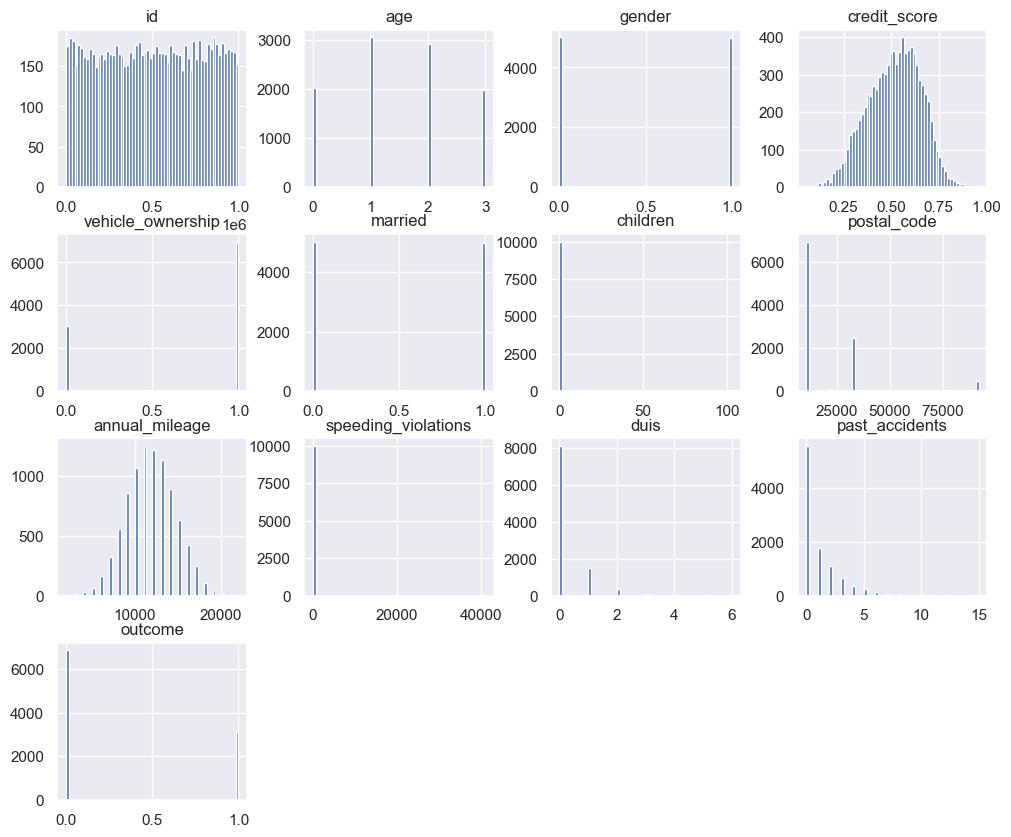

In [50]:
# Histogrammes des variables numériques
df.hist(figsize=(12, 10),bins = 60)
plt.show()


On peut également afficher les valeurs abberantes.

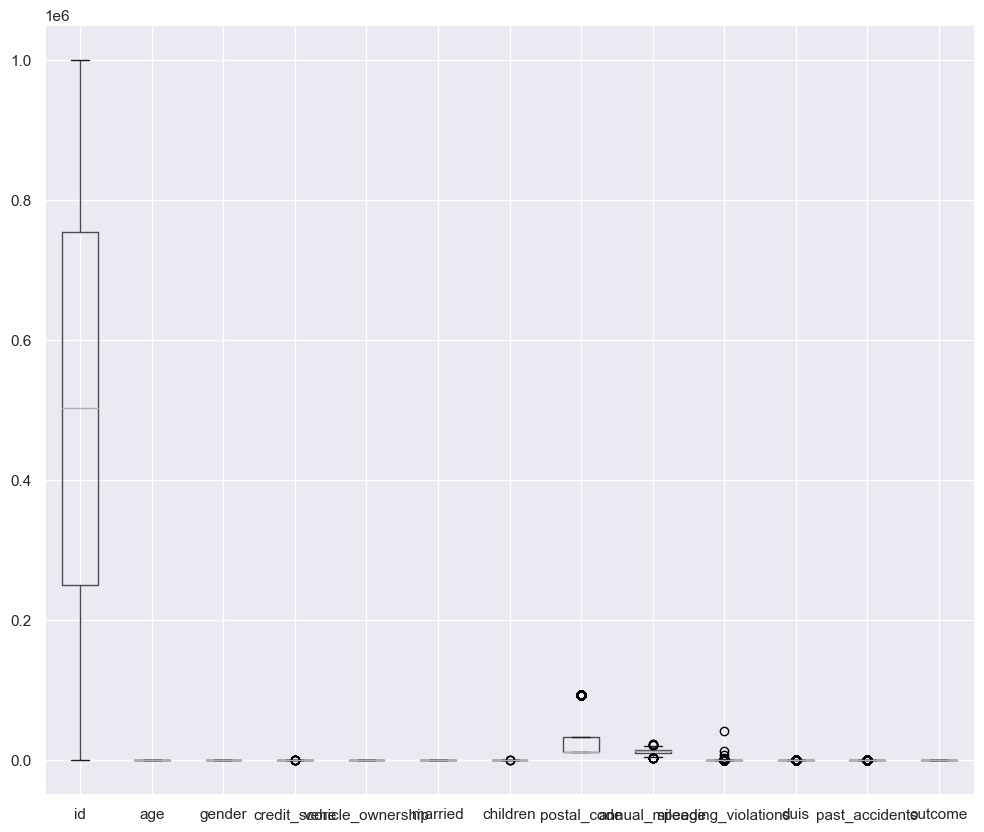

In [51]:
# Boxplots pour détecter les valeurs aberrantes
df.boxplot(figsize=(12, 10))
plt.show()

II - Mise en forme 

Fonctions utiles à la mise en forme des données :

In [52]:
# Dans une dataframe encode les colonnes contenant des labels
def label_encode_columns(df, cols):
    #création d'un encodeur pour label 
    label_encoder = LabelEncoder()
    #pour chaque colonne, transformmer les étiquetets à l'aide de l'encodeur 
    for col in cols:
        df[col] = label_encoder.fit_transform(df[col])
    return df

# Prépare les données pour les rendre exploitable par note algorithme 
def preprocess_data(df):
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist() #colonnes numériques
    numerical_cols.pop() #supprime les outcome 
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()#colonnes catégorique

    # Pipeline pour le traitement des features numériques 
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),  # Imputation par la médiane
        ('scaler', StandardScaler())  # Normalisation des données
    ])

    # Pipeline pour le traitement des features utilisant des labels 
    categorical_transformer = Pipeline(steps=[
        ('label_encoder', FunctionTransformer(lambda df: label_encode_columns(df, categorical_cols), validate=False)),  # Encodage Label
        ('scaler', StandardScaler())  # Normalisation des données
    ])

    # Transformeur l'ensemble des features 
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    # Opérer à la transformation des données 
    df_processed = pd.DataFrame(preprocessor.fit_transform(df))
    df_processed.columns = numerical_cols+categorical_cols
    df_outcome = pd.DataFrame(df['outcome'])

    # Ajouter les vérité terrain en colonne finale de la dataframe 
    df_processed = pd.concat([df_processed, df_outcome], axis=1)

    # Convert the result back to a DataFrame
    return df_processed

#Supprime les valeurs numérique excendant le seuil d'une colonne d'une dataframme
def threshold_cleaner(data,col, threshold):
     for i in range(data[col].shape[0]):
        if data[col][i] > threshold :
            data.loc[i, col] = None

Traitement des données 

In [53]:
# Chemin vers le fichier de données
data_path = 'car_insurance.csv'
processed_data_path = 'processed_car_insurance.csv'

# Charger et examiner les données
data = pd.read_csv(data_path)

# Suppression des features id et postal_code  
data = data.drop('id',axis=1)
data = data.drop('postal_code',axis=1)

# Supression des valeurs abberantes 
threshold_cleaner(data,'children',1)
threshold_cleaner(data,'speeding_violations',30)

# Traiter les données
processed_data = preprocess_data(data)


# Enregistrer les données transformées
processed_data.to_csv(processed_data_path, index=False)
print("sucessfully exported")

sucessfully exported


Vérification des données après traitement :

In [54]:
processed_data.describe()

,age,gender,credit_score,vehicle_ownership,married,children,annual_mileage,speeding_violations,duis,past_accidents,driving_experience,education,income,vehicle_year,vehicle_type,outcome
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000
mean,-4.742873e-17,-6.394885e-18,-2.891909e-16,1.261213e-16,4.689582e-17,5.453415e-17,-1.065814e-17,-4.014566e-17,9.698908e-17,-1.776357e-18,6.394885e-17,1.136868e-17,-1.669775e-17,-1.350031e-17,-1.563194e-17,0.313300
std,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,0.463858
min,-1.452849e+00,-9.980020e-01,-3.543204e+00,-1.516684e+00,-9.966058e-01,-1.488433e+00,-3.627054e+00,-6.614616e-01,-4.310201e-01,-6.392632e-01,-1.079662e+00,-1.087026e+00,-1.549750e+00,-1.515607e+00,-2.238063e-01,0.000000
25%,-4.774554e-01,-9.980020e-01,-6.515707e-01,-1.516684e+00,-9.966058e-01,-1.488433e+00,-6.436659e-01,-6.614616e-01,-4.310201e-01,-6.392632e-01,-1.079662e+00,-1.087026e+00,-5.577197e-01,-1.515607e+00,-2.238063e-01,0.000000
50%,-4.774554e-01,-9.980020e-01,6.357930e-02,6.593332e-01,-9.966058e-01,6.718473e-01,1.021810e-01,-6.614616e-01,-4.310201e-01,-6.392632e-01,-6.997154e-02,2.547630e-02,4.343110e-01,6.598015e-01,-2.238063e-01,0.000000
75%,4.979387e-01,1.002002e+00,6.950002e-01,6.593332e-01,1.003406e+00,6.718473e-01,4.751045e-01,2.306573e-01,-4.310201e-01,5.711187e-01,9.397188e-01,1.137979e+00,4.343110e-01,6.598015e-01,-2.238063e-01,1.000000
max,1.473333e+00,1.002002e+00,3.395927e+00,6.593332e-01,1.003406e+00,6.718473e-01,3.831416e+00,9.151846e+00,1.038052e+01,8.438601e+00,1.949409e+00,1.137979e+00,1.426342e+00,6.598015e-01,4.468150e+00,1.000000


On remarque que l'écart type est bien de 1 pour l'ensemble des features

III - Training

Fonctions utiles à l'entrainement du modèle

Le jeux d'entrainement et de validation correspondent respectivement à 80% et 20% du jeu total de données. Ces paramètres sont définis dans la fonction split_data.

In [55]:
# Transformer les données en jeux d'entrainement et de test 
def split_data(df, test_size=0.2, random_state=42):
    #dissocier features et outcome
    X = df.drop('outcome', axis=1) 
    y = df['outcome']
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

# Entrainer le modèle avec l'algorithme de regression logistic
def train_logistic_regression(X_train, y_train):
    # Paramètres pour la recherche de grille
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear'],
        'max_iter': [200, 300, 500]
    }

    # Initialiser le modèle de régression logistique
    log_reg = LogisticRegression()

    # Initialiser GridSearchCV avec validation croisée
    grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Entraîner le modèle avec le GridSearchCV
    grid_search.fit(X_train, y_train)
    print(f"Best Parameters: {grid_search.best_params_}")

    # Retourner le meilleur modèle trouvé
    return grid_search.best_estimator_

Entrainement du modèle de régression logistique

In [56]:
# Chargement des données
data_path = 'processed_car_insurance.csv'
data = pd.read_csv(data_path)

# Préparation du set d'entrainement 
X_train, X_test, y_train, y_test = split_data(data)

# Entraînement du modèle de régression logistique
logistic_model = train_logistic_regression(X_train, y_train)

# Sauvegarde du modèle
joblib.dump(logistic_model, 'final_model.joblib')

Best Parameters: {'C': 0.1, 'max_iter': 200, 'solver': 'liblinear'}


['final_model.joblib']

IV - Evaluation

Fonction utile à l'évaluation de modèles

In [57]:
#Procéde à l'évaluation générale du modèle 
def evaluate_model(model, X_test, y_test): 
    
    predictions = model.predict(X_test)
    acc = accuracy_score(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)
    
    precision = precision_score(y_test, predictions, average='binary')
    recall = recall_score(y_test, predictions, average='binary')
    f1 = f1_score(y_test, predictions, average='binary')
    report = classification_report(y_test, predictions)

    print("Accuracy:", acc)
    print("Confusion Matrix:\n", cm)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("\nClassification Report:\n", report)

#Procède à la validation croisée du modèle
def perform_cross_validation(model, X, y):
    cross_validator = KFold(n_splits=5, shuffle=True, random_state=42)
    acc_scores = cross_val_score(model, X, y, cv=cross_validator, scoring='accuracy')
    print("Cross-Validation Scores:", acc_scores)
    print("Mean Accuracy:", acc_scores.mean())
    print("Standard Deviation:", acc_scores.std())

#Procède à l'analyse des correlations
def analyze_correlations(df, target_column_index):
    corr_matrix = df.corr()
    sns.set (rc = {'figure.figsize':(15, 15)})
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm') 
    plt.title('Heatmap des Corrélations')
    #sns.set_theme(rc={'figure.figsize':(15, 15)})
    plt.show()

    scatter_matrix(df, figsize=(15, 15), diagonal='kde')
    plt.show()

Evaluation du modèle de regression logistique

Différentes métriques permettents de mesurer les résultats de notre algorithme : L'accuracy, la précision, le recall et le score F1 

L'accuracy mesure la proportion de prédictions correctes parmi l'ensemble des prédictions effectuées.
Acc = Nombre_Prédictions_Correctes/Nombre_Prédictions_Effectués

La précision mesure la proportion des prédictions positives correctes parmi l'ensemble des prédictions positives effectuées.
Pre = TruePositif/TruePositif+FalsePositif

Le rappel mesure la proportion des vrais positifs détectés parmi l'ensemble des exemples réellement positifs. 
Rap =  TruePositif/TruePositif+FalseNegatif

Le score F1 est la moyenne harmonique de la précision et du rappel, offrant un équilibre entre les deux métriques.
F1 = 2*Pre*Rap/(Pre+Rappel)
​

In [58]:
# Chargement du modèle
model_path = 'final_model.joblib'
model = joblib.load(model_path)

# Évaluation générale du modèle
evaluate_model(model, X_test, y_test)

Accuracy: 0.8445
Confusion Matrix:
 [[1242  125]
 [ 186  447]]
Precision: 0.7814685314685315
Recall: 0.7061611374407583
F1 Score: 0.741908713692946

Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.91      0.89      1367
         1.0       0.78      0.71      0.74       633

    accuracy                           0.84      2000
   macro avg       0.83      0.81      0.82      2000
weighted avg       0.84      0.84      0.84      2000



La précision générale est assez bonne, 87% pour les négatifs et 78% pour les positifs, de même, le recal est de 91% pour les positifs et 71% pour les négatifs. L'algorithme est assez fiable dans l'ensemble, il a tendance a privilégier la sortie négative ce qui explique le nombre de FalseNegative assez grand en comparaison au nombre de TruePositive

Crossvalidation

La crossvalidation permet de valider l'efficacité de son modèle en utilisant l'ensemble des données disponibles pour l'entraînement et la validation. Les résulats sont assez proches des résultats précédents, mais sont normalement plus représentatif. En effet, lors de l'évaluation classique, les données sont divisées en ensembles d'entraînement et de validation, ce qui peut introduire une variabilité significative dans l'évaluation du modèle.

In [59]:
perform_cross_validation(model, X_test, y_test)

Cross-Validation Scores: [0.83   0.8575 0.8575 0.83   0.8575]
Mean Accuracy: 0.8465
Standard Deviation: 0.013472193585307518


On atteint une Accuracy de 84% avec validation croisé

Affichage de la matrice de correlation et scatter

Définition coeff corrélations :  

On remarque que l'age est le feature qui présente le plus de corrélation avec les autres, cette feature apporte donc beaucoup d'information. A l'inverse le type de véhicule est décoréllé de tout les autres facteurs, il semble donc être sans importance. Les 5 variables les plus pertinentes sont l'age, les speedings_violations, la driving expérience, le duis et les past accident, ces variables sont fortements liés à la sortie

La scatter matrix offre une autre vue de la relation entre les variables. Quand les points sont dispersés, la relation entre les features est faible, si les points sont concentrés, la relation est forte. En soit les informations apportés par la matrice de corrélation et la scatter matrix sont similaire  mais les vues sont différentes

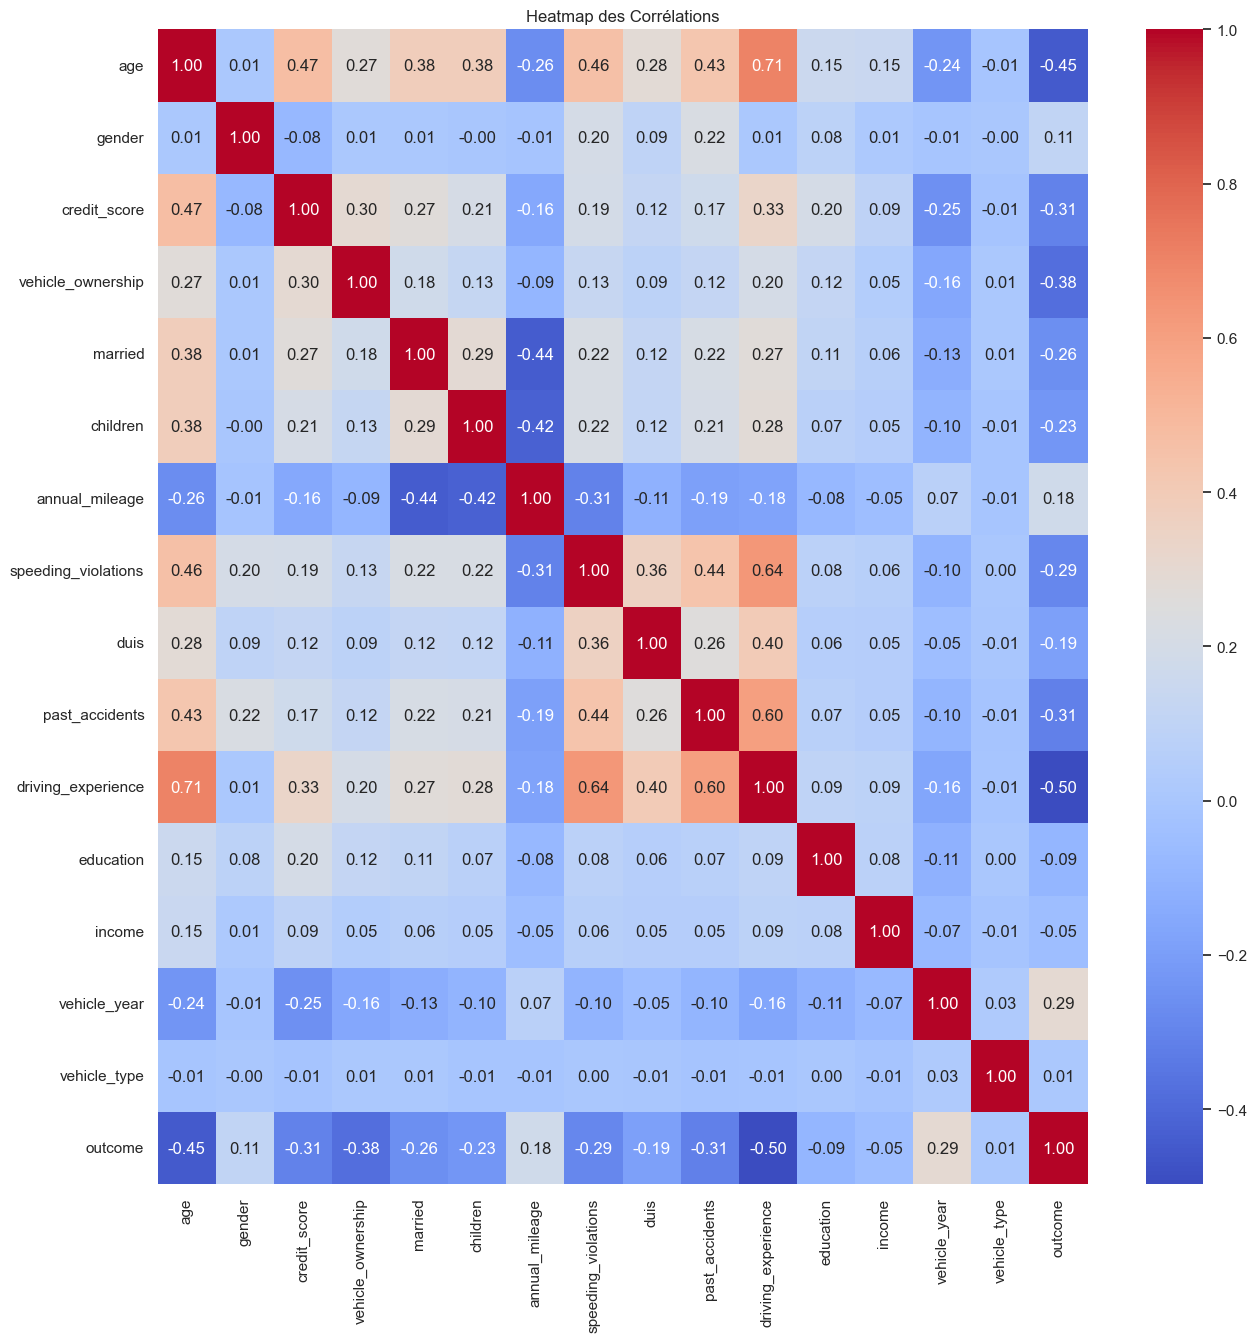

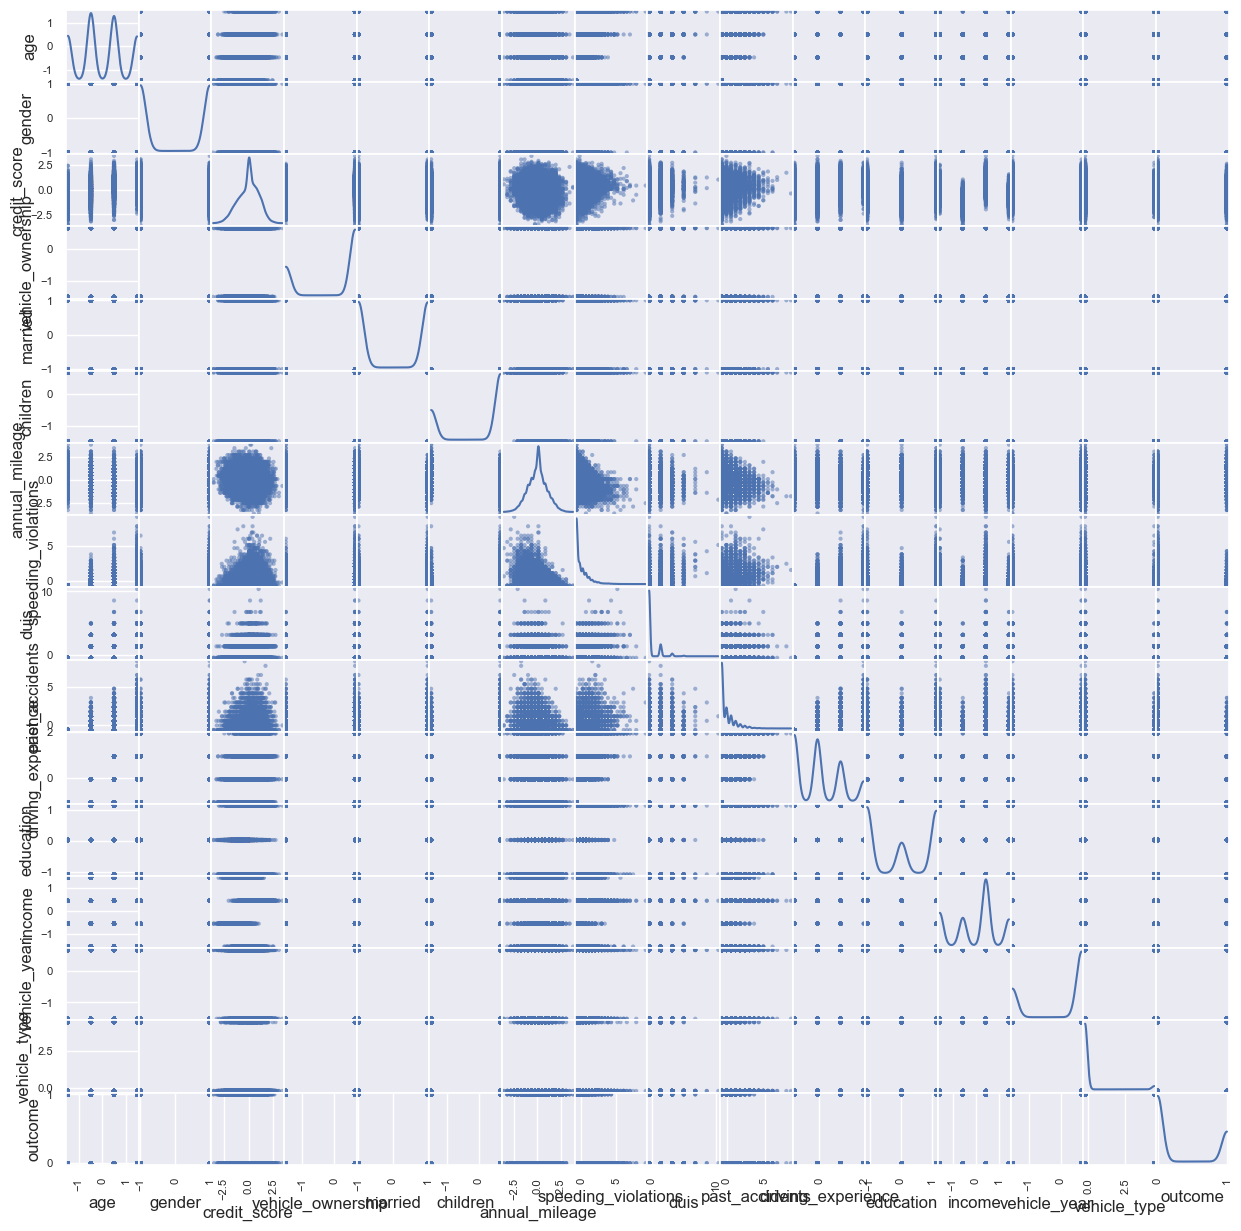

In [60]:
analyze_correlations(data,'outcome',)

Training multi modèle

model__C : Ce paramètre contrôle la régularisation de la régression logistique. Plus la valeur de C est petite, plus la régularisation est forte.
Valeurs à essayer : [0.1, 1, 10, 100].

model__n_estimators : Ce paramètre contrôle le nombre d'arbres dans la forêt (RandomForest) ou le nombre de voisins à utiliser pour la classification (KNN).

model__gamma : Ce paramètre contrôle le coefficient l'influence d'un seul exemple d'entraînement. Plus gamma est grand, plus la portée de l'influence est faible.

model__alpha : Ce paramètre contrôle la régularisation (équivalent de C pour les modèles linéaires avec régularisation).

model__penalty : Ce paramètre contrôle le type de pénalité à utiliser pour la régularisation.

penalty : Type de régularisation ('l2' pour la régularisation de Ridge, 'l1' pour la régularisation de Lasso, 'elasticnet' pour une combinaison des deux).


In [61]:
#Entraine notre modèle en testant différents algorthime afin d'extraire les meilleurs paramètres pour chacun d'entre eux 
def train_best_model(X_train, y_train):

    #définition des différents modèle utilisé durant les entrainements 
    models = {
        'LogisticRegression': LogisticRegression(max_iter=1000),
        'RandomForest': RandomForestClassifier(),
        'SVC': SVC(),
        'KNN': KNeighborsClassifier(),
        'Perceptron': Perceptron(max_iter=1000)
    }

    #définition des différents paramètre à essayer pour chaque algorithme 
    params = {
        'LogisticRegression': {'model__C': [0.1, 1, 10, 100]},
        'RandomForest': {'model__n_estimators': [10, 50, 100]},
        'SVC': {'model__C': [0.1, 1, 10], 'model__gamma': [0.001, 0.01, 0.1]},
        'KNN': {'model__n_neighbors': [3, 5, 7]},
        'Perceptron': {'model__alpha': [0.0001, 0.001, 0.01, 0.1], 'model__penalty': ['l2', 'l1', 'elasticnet']}
    }

    best_models = {}
    #pour chaque algorithme entrainer le modèle et rechercher les meilleurs hyper paramètres
    for name, model in models.items():
        pipe = Pipeline([('model', model)])
        grid_search = GridSearchCV(pipe, params[name], cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        #ajout du meilleur modèle au dictionnaire best_models
        best_models[name] = grid_search.best_estimator_
        print(f"Best Parameters for {name}: {grid_search.best_params_}")

    return best_models

best_models = train_best_model(X_train, y_train)

model_names = ['LogisticRegression', 'RandomForest', 'SVC', 'KNN','Perceptron']
for name,model in best_models.items():
        # Sauvegarde du modèle
        joblib.dump(model, f'{name}.joblib')

Best Parameters for LogisticRegression: {'model__C': 1}
Best Parameters for RandomForest: {'model__n_estimators': 100}
Best Parameters for SVC: {'model__C': 1, 'model__gamma': 0.01}
Best Parameters for KNN: {'model__n_neighbors': 7}
Best Parameters for Perceptron: {'model__alpha': 0.0001, 'model__penalty': 'elasticnet'}


Evaluation de tout les meilleurs modèles entrainés précèdemment

In [62]:
for model_name in model_names:
    try:
        # Chargement du modèle
        model_path=f"{model_name}.joblib"
        model = joblib.load(model_path)

        # Évaluation du modèle sur les données de test
        print(f"\nÉvaluation sur le jeu de test pour le modèle {model_name} :")
        evaluate_model(model, X_test, y_test)
        # Validation croisée sur l'ensemble des données
        print(f"\nValidation croisée pour le modèle {model_name} :")
        perform_cross_validation(model, X_test, y_test)
        print("_________________________________________________________________\n")
    except FileNotFoundError:
        print(f"Modèle {model_name} non trouvé à {model_path}.")


Évaluation sur le jeu de test pour le modèle LogisticRegression :
Accuracy: 0.844
Confusion Matrix:
 [[1243  124]
 [ 188  445]]
Precision: 0.7820738137082601
Recall: 0.7030015797788309
F1 Score: 0.7404326123128119

Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.91      0.89      1367
         1.0       0.78      0.70      0.74       633

    accuracy                           0.84      2000
   macro avg       0.83      0.81      0.81      2000
weighted avg       0.84      0.84      0.84      2000


Validation croisée pour le modèle LogisticRegression :
Cross-Validation Scores: [0.825  0.8575 0.8625 0.83   0.8575]
Mean Accuracy: 0.8465
Standard Deviation: 0.015700318468107623
_________________________________________________________________


Évaluation sur le jeu de test pour le modèle RandomForest :
Accuracy: 0.819
Confusion Matrix:
 [[1239  128]
 [ 234  399]]
Precision: 0.7571157495256167
Recall: 0.6303317535545023
F1 Sc

Conclusion, la regression Logistic est la plus performante dans notre cas d'usage